# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [168]:
import os
import sys
from numpy import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import distance

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.flowchart import flowchart

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
FLOWCHART_WEIGHTS_PATH = "mask_rcnn_balloon.h5"  # TODO: update this path

## Configurations

In [169]:
config = flowchart.FlowchartConfig()
FLOWCHART_DIR = os.path.join(ROOT_DIR, "FlowchartDataMRCNN")

In [170]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                24
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [171]:
# Device to load the neural network on.
# Useful if you're training a model on the same
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [172]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [173]:
# Load validation dataset
dataset = flowchart.FlowchartDataset()
dataset.load_flowcharts(FLOWCHART_DIR, "TestingImages")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

C:\Users\CADuser\Documents\johanna\FlowchartMRCNN\FlowchartDataMRCNN\TestingImages
Images: 3
Classes: ['BG', 'terminal_start', 'flowline', 'input', 'decision', 'process', 'terminal_end', 'process_end', 'process_start', 'connector', 'document', 'terminal']


## Load Model

In [174]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [175]:
# Set path to flowchart weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:\Users\CADuser\Documents\johanna\FlowchartMRCNN\logs\flowchart20200609T1207\mask_rcnn_flowchart_0030.h5
Re-starting from epoch 30


## Run Detection

image ID: flowchart.00000017.jpg (0) C:\Users\CADuser\Documents\johanna\FlowchartMRCNN\FlowchartDataMRCNN\TestingImages\00000017.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 24)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


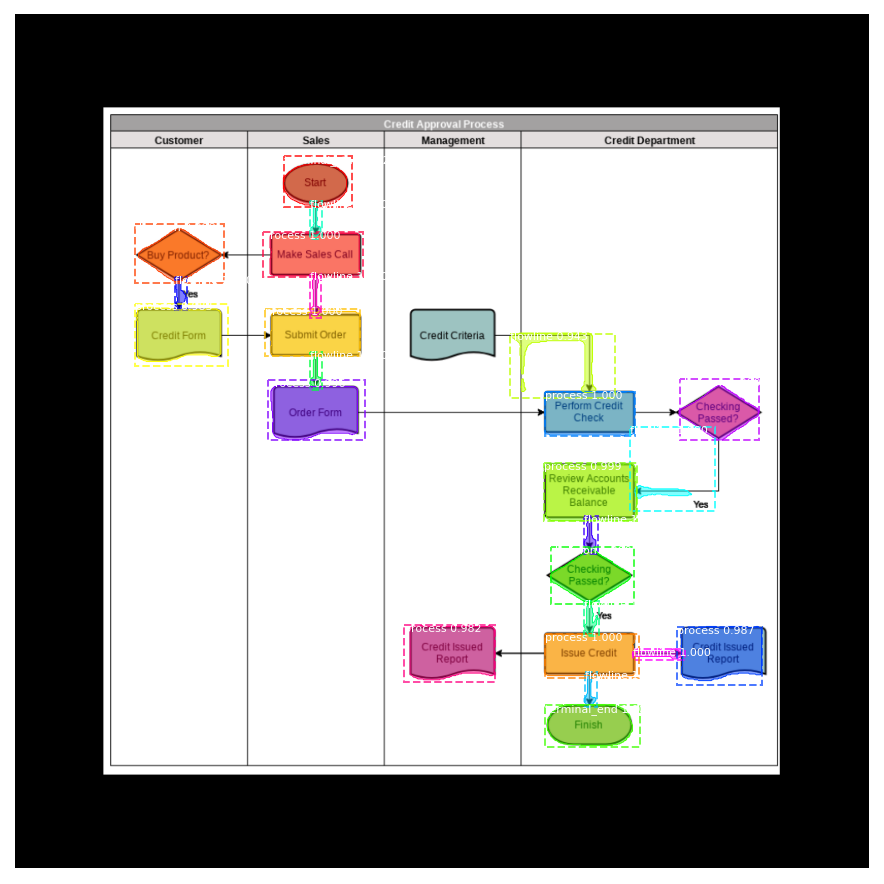

gt_class_id              shape: (30,)                 min:    1.00000  max:   10.00000  int32
gt_bbox                  shape: (30, 4)               min:  143.00000  max:  903.00000  int32
gt_mask                  shape: (1024, 1024, 30)      min:    0.00000  max:    1.00000  bool


In [176]:
##Change from image to img_list where img_list==BATCH_SIZE (BS == IMAGES_PER_GPU * GPU_COUNT) to run on multiple GPUs
image_ids = random.choice(dataset.image_ids, config.BATCH_SIZE)

images = []
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    images.append(image)
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect(images, verbose=1)
#masks = []
for i, image in enumerate(images):
    r = results[i]
    #masks.append(r['masks'])
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                                dataset.class_names, r['scores'])
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

In [15]:
def masks_overlap(current_mask, mask2):
    m1array = []
    m2array = []

    current_flattened = set(current_mask.flatten())
    mask2_flattened = set(mask2.flatten())

    for index, m in enumerate(current_flattened):
        if m:
            m1array.append(index)
    for ind, n in enumerate(mask2_flattened):
        if n:
            m2array.append(ind)
    # TODO: FIND SOLUTION FOR ALMOST OVERLAPPING MASKS/MASKS THAT ARE VERY NEAR TO EACH OTHER
    # if current_inde == 0 and inde == 2:
    #     print("")
    mindist = np.min(distance.cdist(m1array, m2array))
    print(mindist)
    for number in m1array:
        if number in m2array:
            return True
    return False

In [16]:
def find_start_mask_id(class_ids, start_terminal):
    for index, id in enumerate(class_ids):
        if id == start_terminal:
            return index
    return False

In [17]:
def find_next_mask(class_ids, masks, current_index, flowchart_mask_order):
    next_index = None
    next_id = None

    for index, id in enumerate(class_ids):

        potential_mask = masks[:, :, index]
        current_mask = masks[:, :, current_index]
        overlap = masks_overlap(current_mask, potential_mask)

        if overlap and index != current_index and index not in flowchart_mask_order:
            next_index = index
            next_id = id
            break

    return next_index, next_id

In [18]:
def build_flowchart_order(class_ids, masks, current_index, flowchart_class_order, flowchart_mask_order):
    next_index, next_id = find_next_mask(class_ids, masks, current_index, flowchart_mask_order)
    if next_index is not None and next_id is not None:
        if next_index not in flowchart_mask_order:
            flowchart_class_order.append(next_id)
            flowchart_mask_order.append(next_index)
            build_flowchart_order(class_ids, masks, next_index, flowchart_class_order, flowchart_mask_order)
        else:
            return flowchart_class_order, flowchart_mask_order
    else:
        return flowchart_class_order, flowchart_mask_order


In [19]:
# iterate through masks
# find mask which overlaps the start mask (start terminal)

r = results[0]
flowchart_class_order = []
flowchart_mask_order = []

#Extract the first mask (start_terminal)
masks = r['masks']
class_ids = r['class_ids']
start_id = 1
start_index = find_start_mask_id(class_ids, start_id)

if start_index:
    flowchart_class_order.append(start_id)
    flowchart_mask_order.append(start_index)
    build_flowchart_order(class_ids, masks, start_index, flowchart_class_order, flowchart_mask_order)
else:
    print('No start_terminal was found!')


ValueError: XA must be a 2-dimensional array.

C:\Users\CADuser\anaconda3\envs\FlowchartMRCNN\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


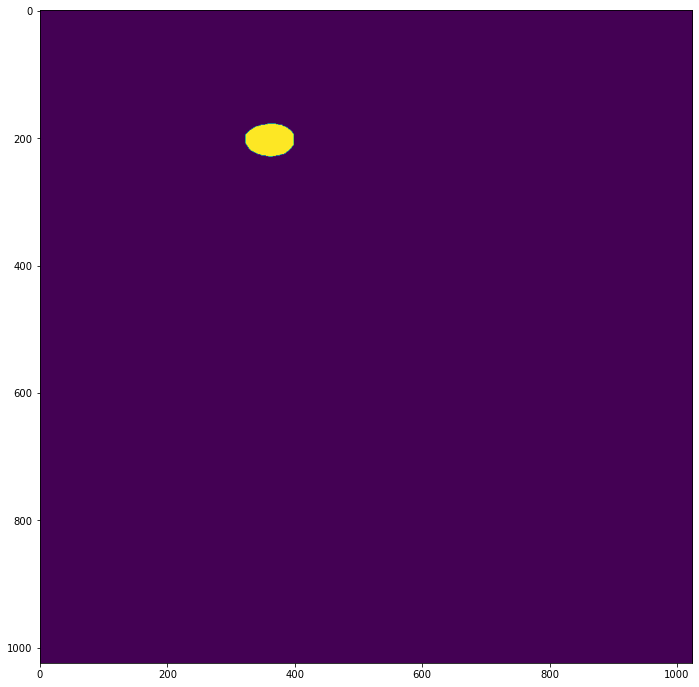

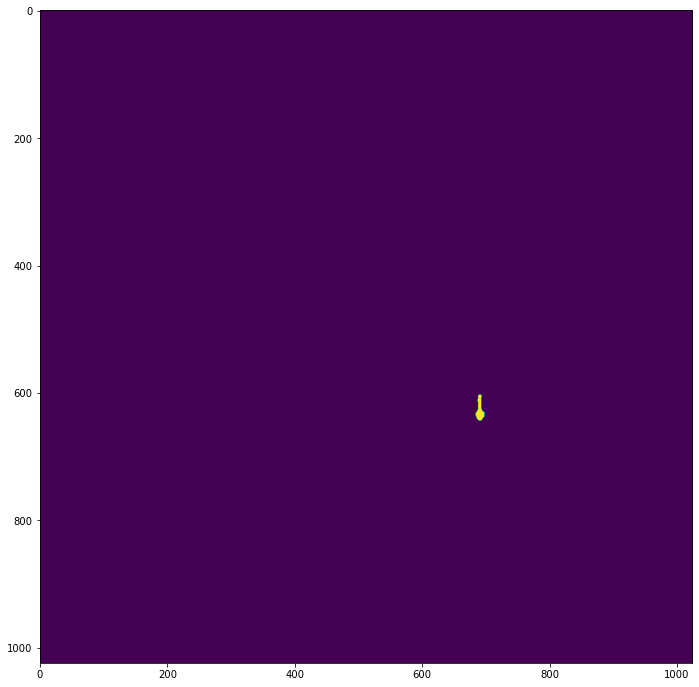

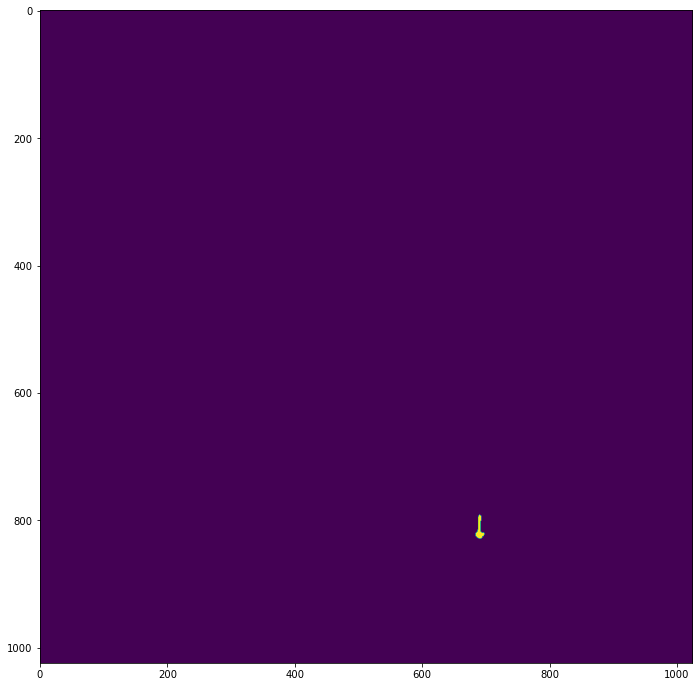

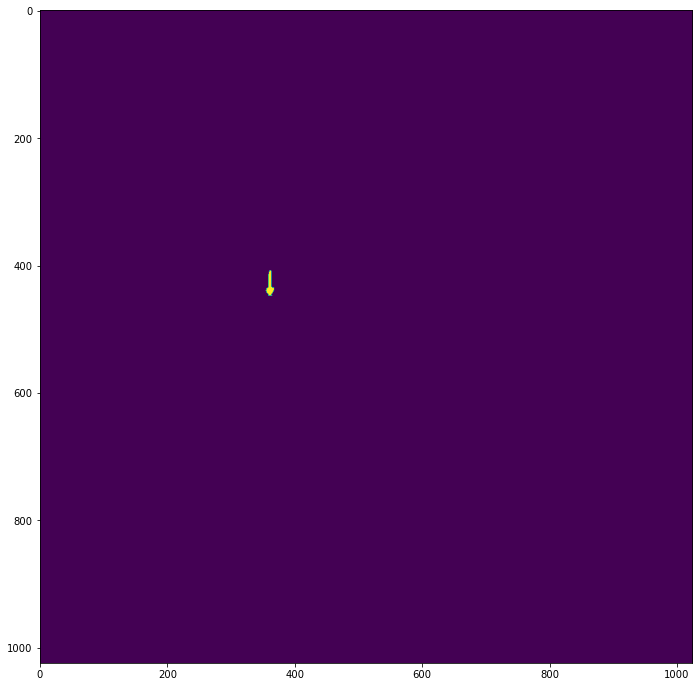

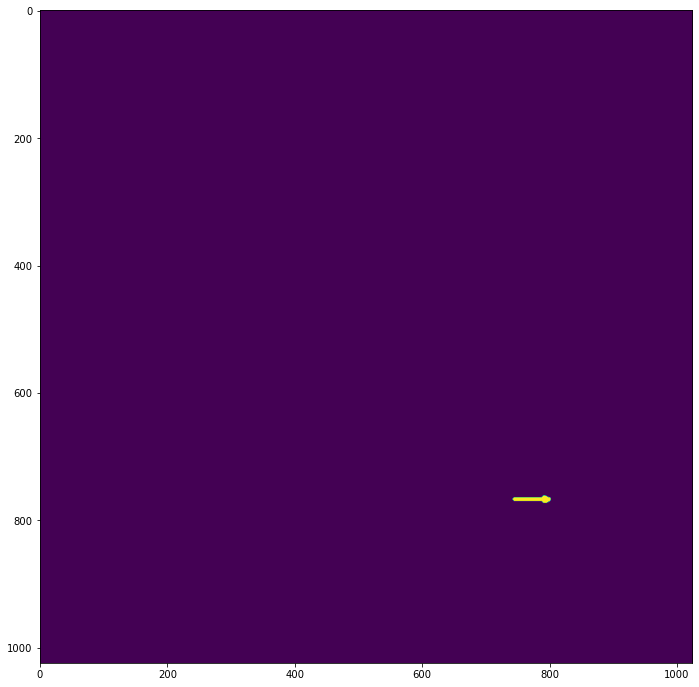

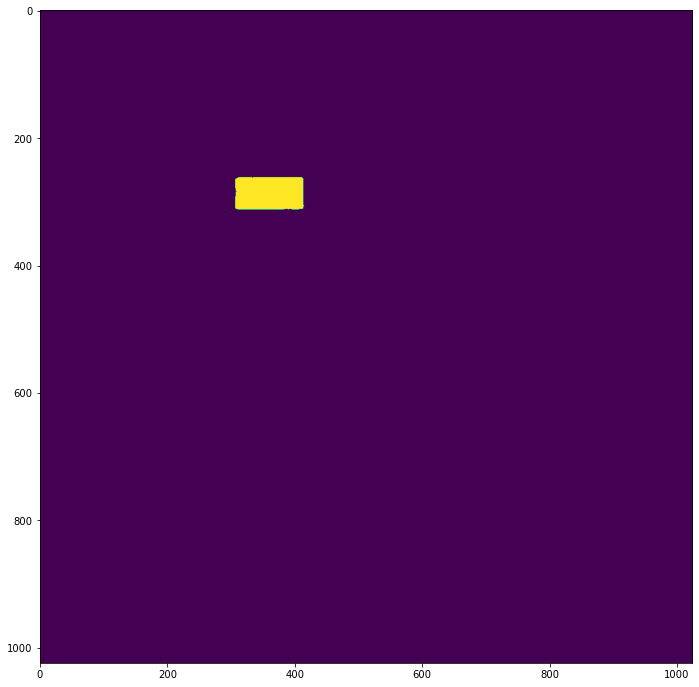

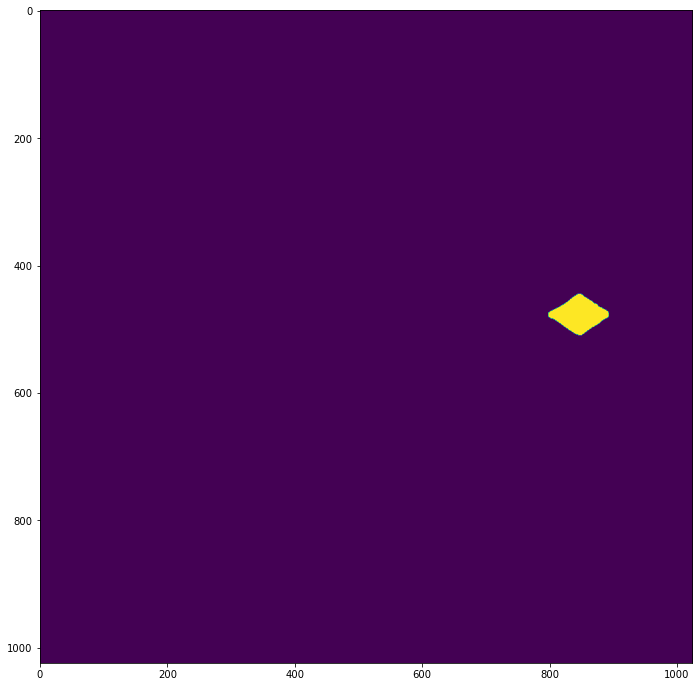

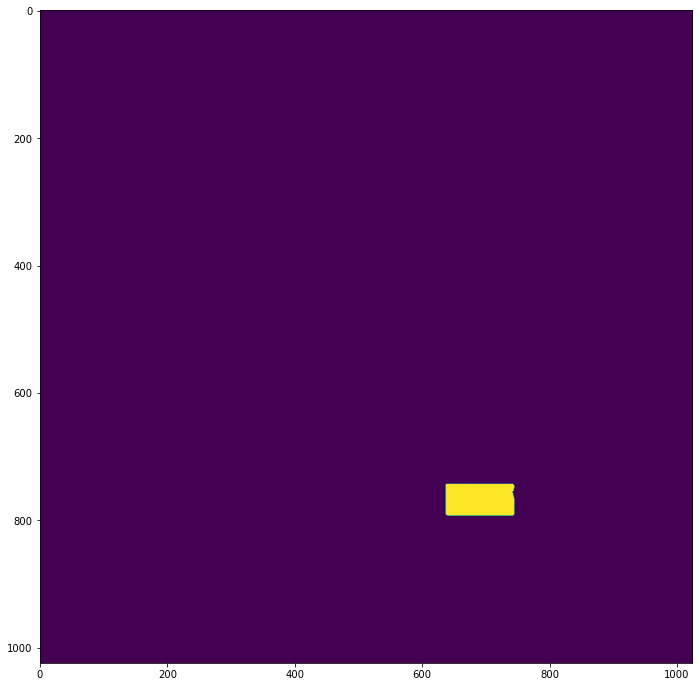

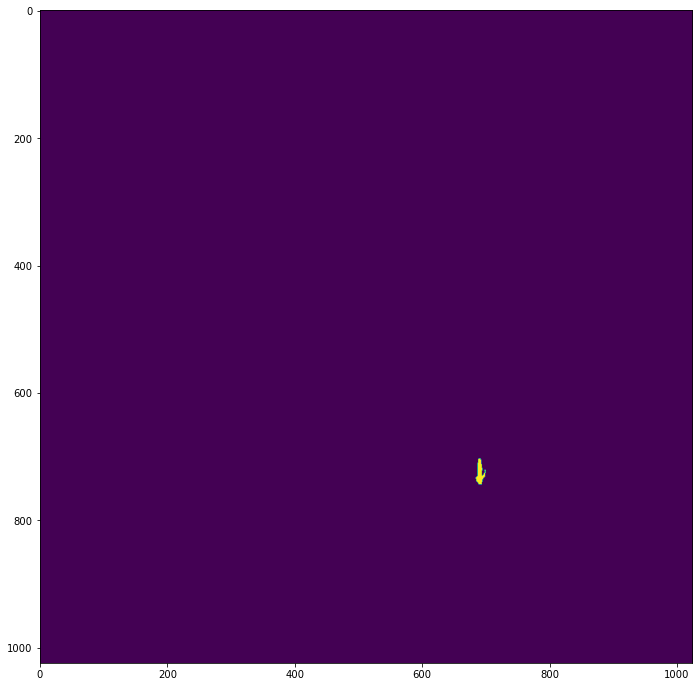

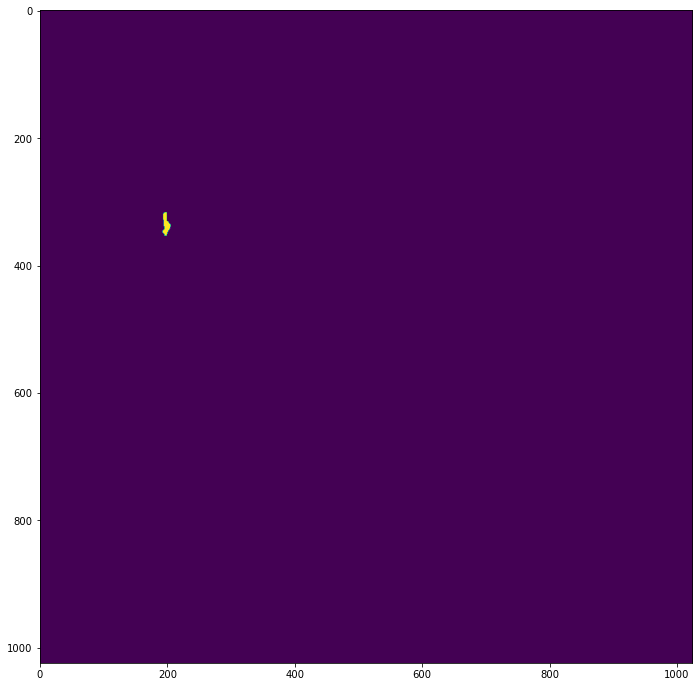

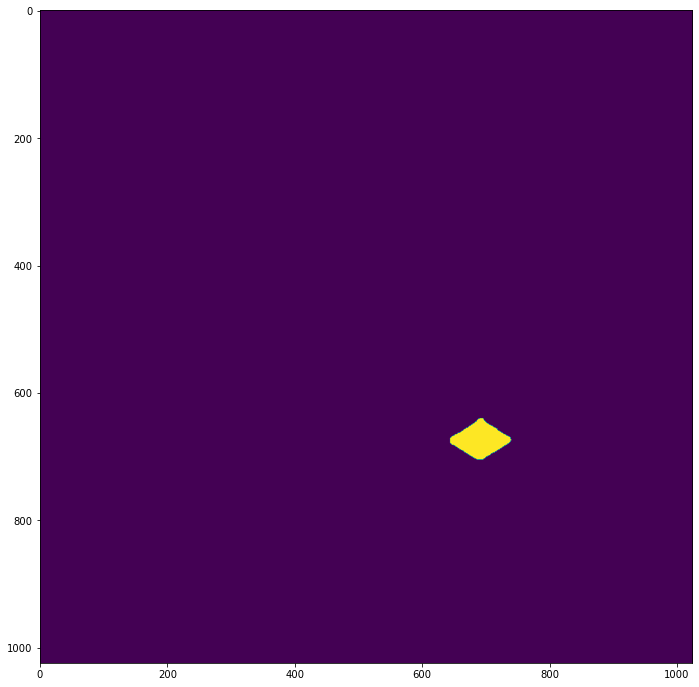

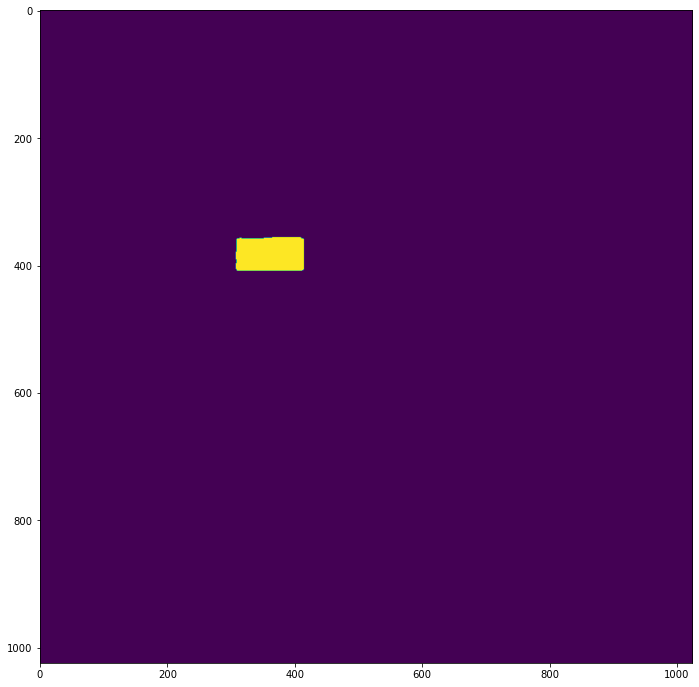

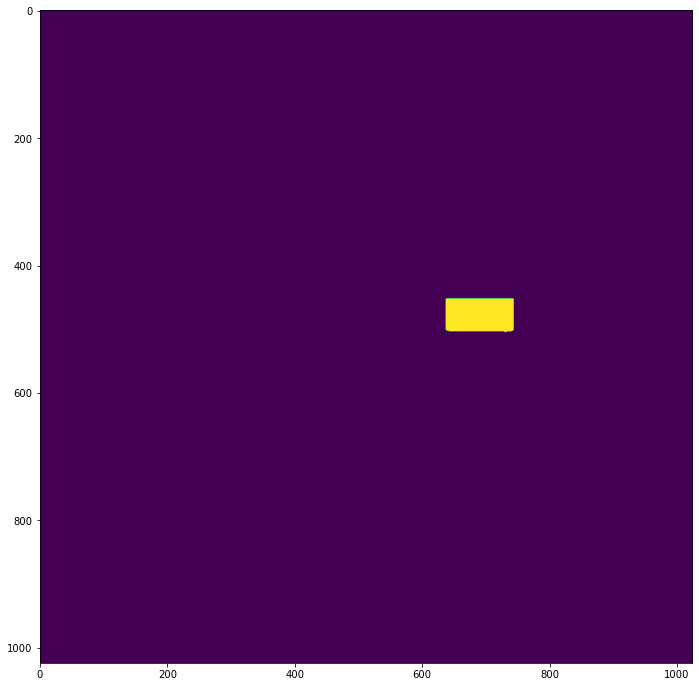

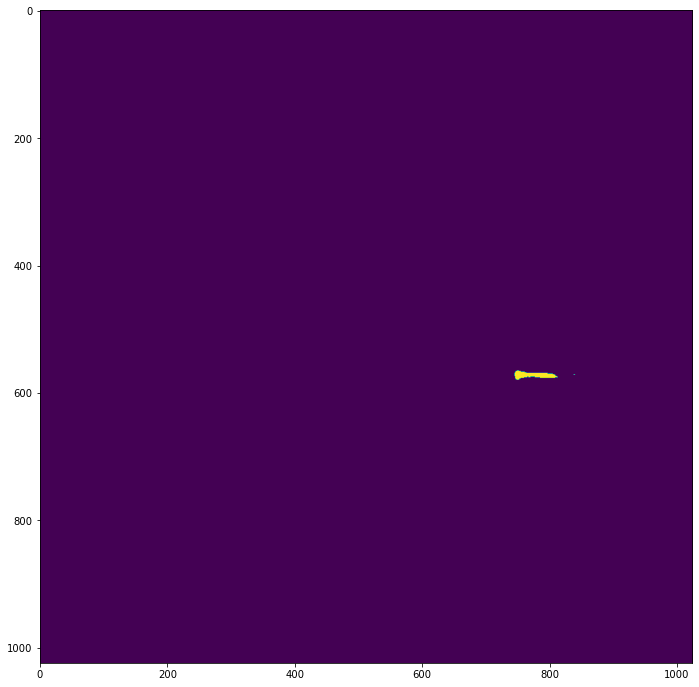

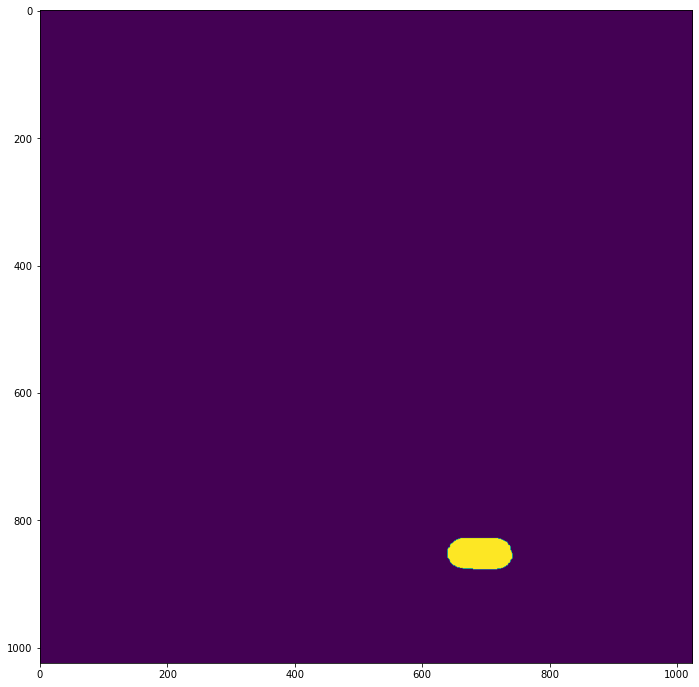

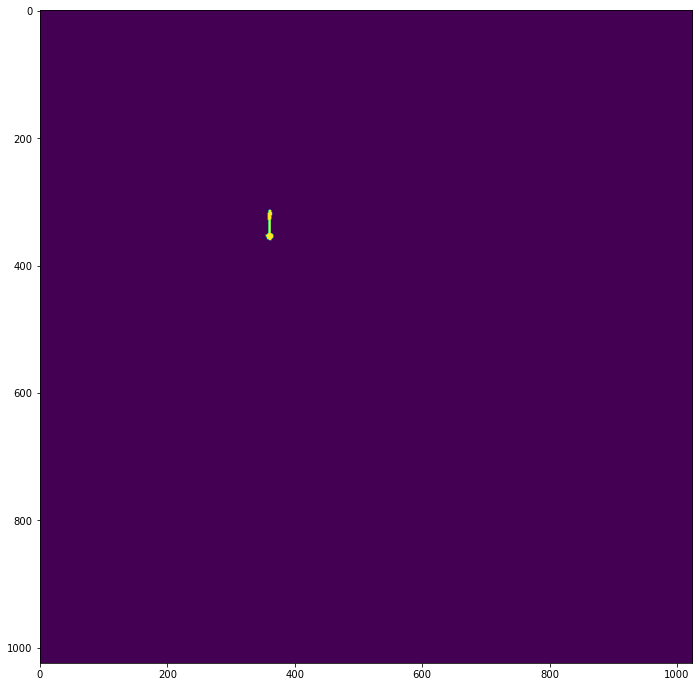

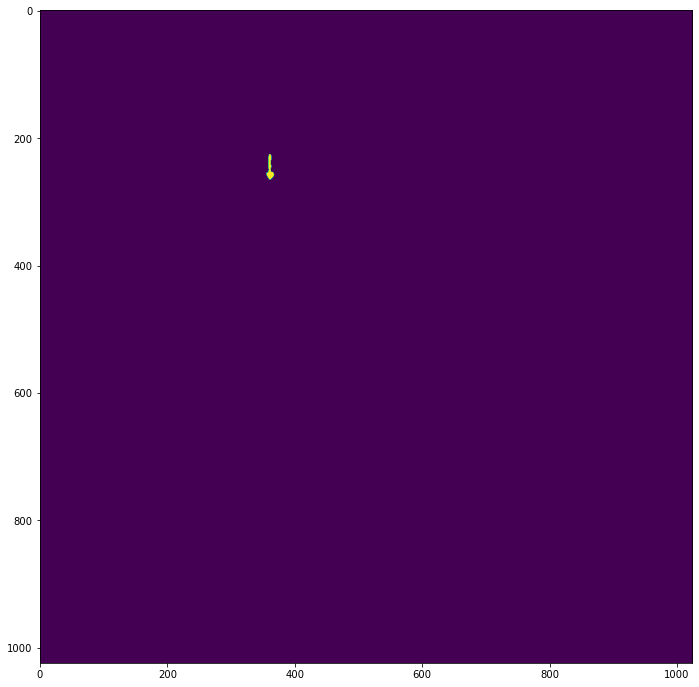

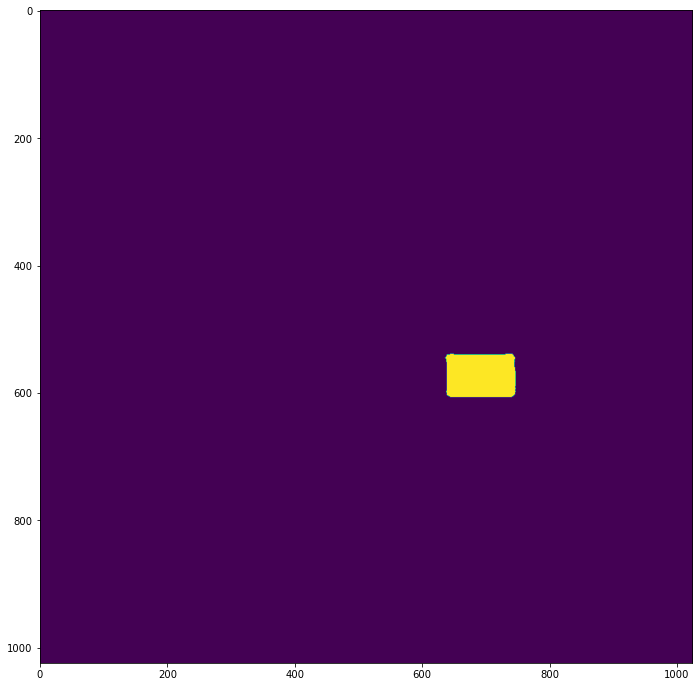

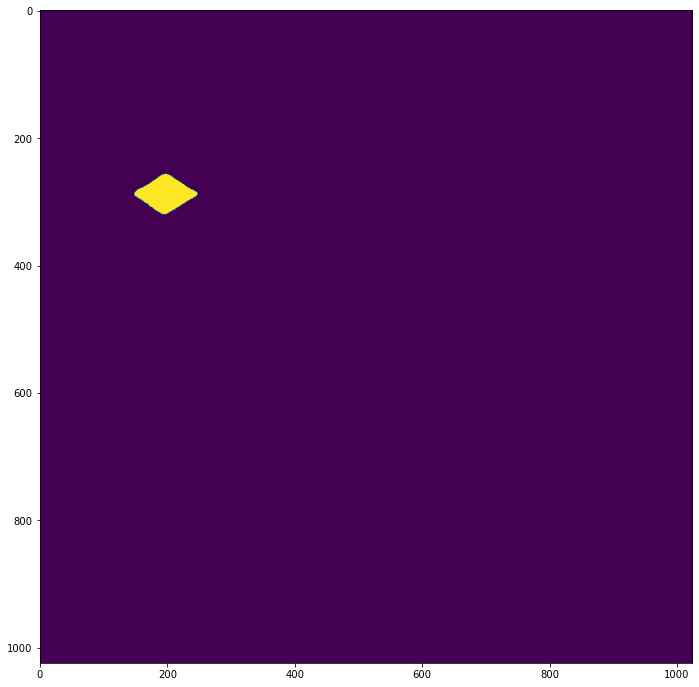

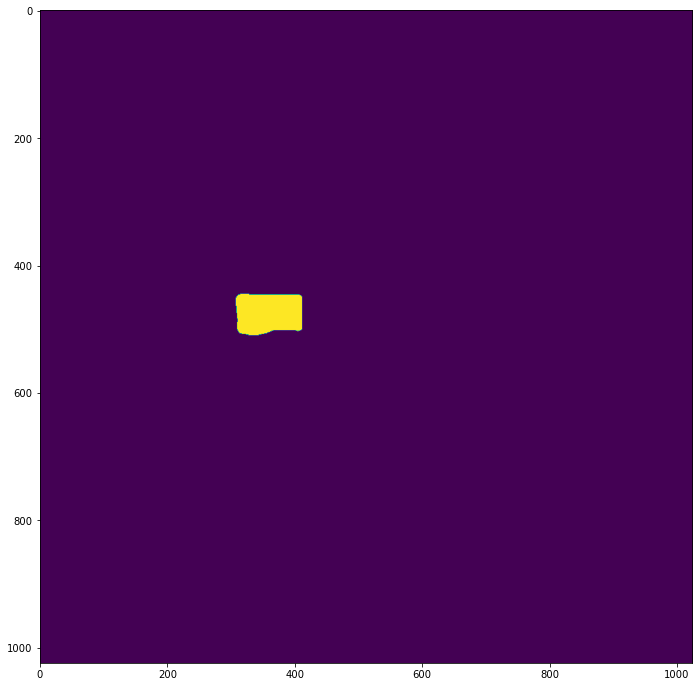

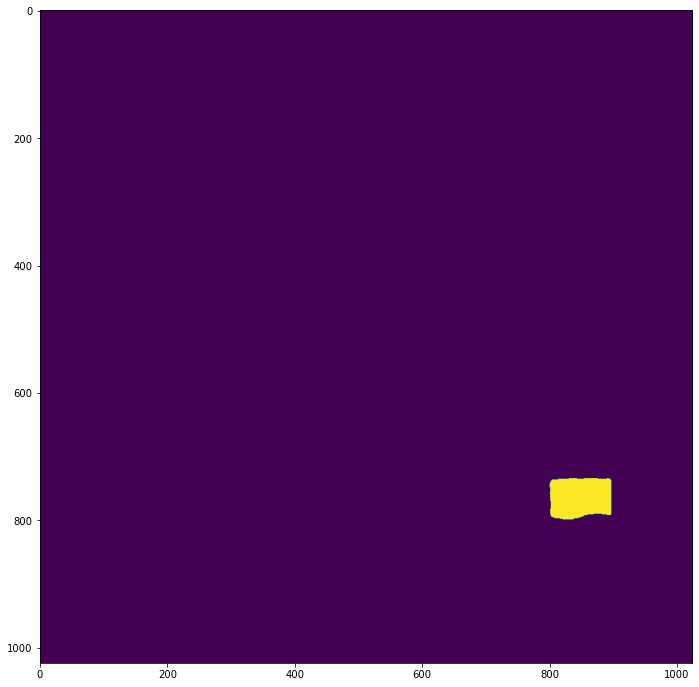

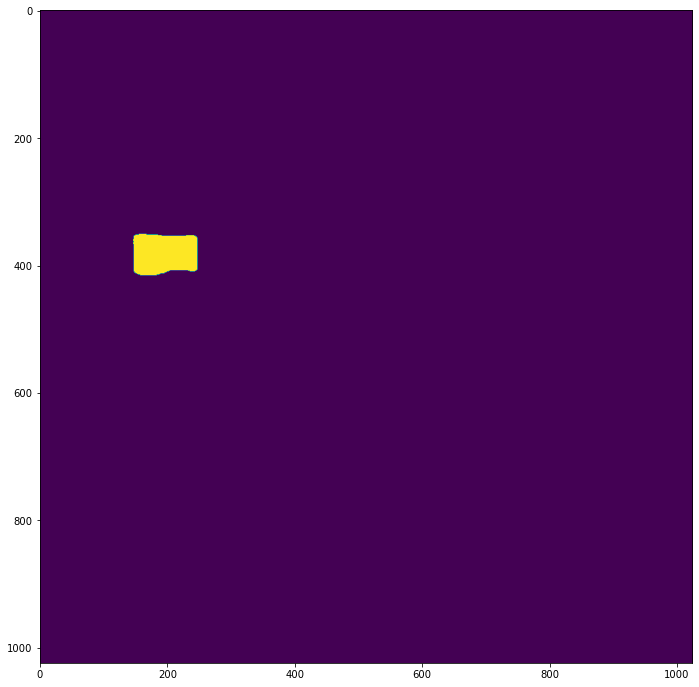

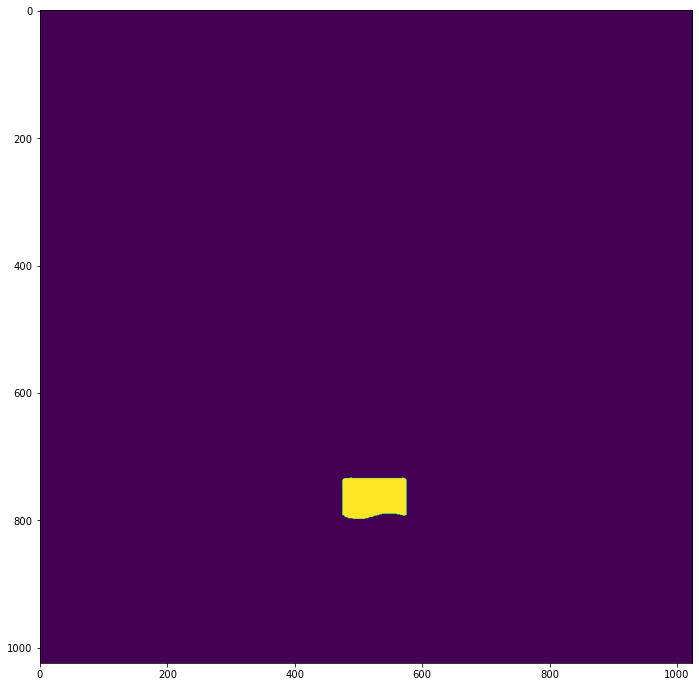

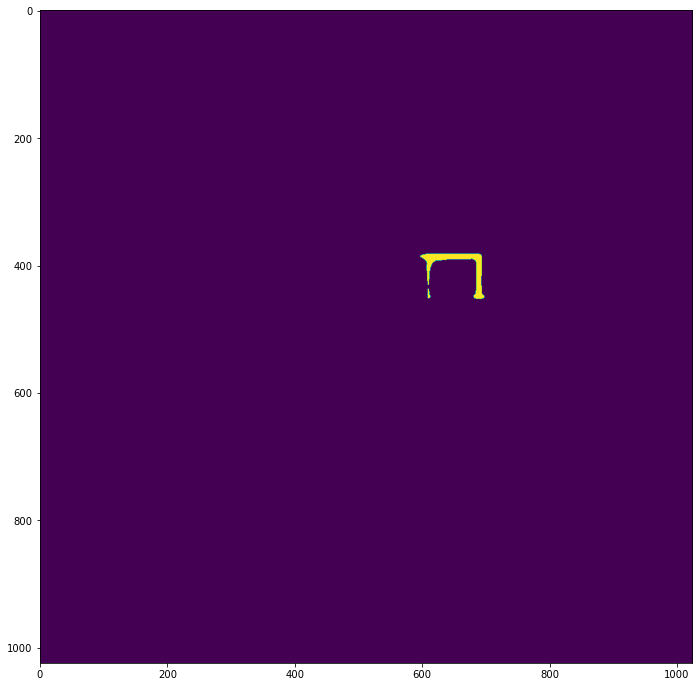

In [182]:
for mask in flowchart_mask_order:
    next_mask = masks[:, :, mask]
    plt.figure(figsize=(12, 12))
    plt.imshow(next_mask)


In [183]:
for flowchart_symbol in flowchart_class_order:
    next_symbol = dataset.class_names[flowchart_symbol]
    print(next_symbol)


terminal_start
flowline
flowline
flowline
flowline
process
decision
process
flowline
flowline
decision
process
process
flowline
terminal_end
flowline
flowline
process
decision
process
process
process
process
flowline
